In [191]:
from utils.paths_to_files import *
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_palette("Set2")
import matplotlib.pyplot as plt
import IPython.display as ipd
from utils.utils import *
from utils.classificationEvaluation import *
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier, plot_importance

# 1. Defining the task and splitting the data
In this lab we will use LDA to reduce the dimensionality of the dataset and perform genre classification on the transformed features. LDA performs a rather strong dimensionality reduction (in our case it will reduce the number of features from 324 to 15) and it is very likely that this new transformation of the features will not be representative of the tracks themselves.
Afterwards, we will fit two models: multinomial logistic regression and XGB classifier (ensamble method)

In [192]:
df = pd.read_csv(FEATURES_PATH_PROCESSED, index_col=0, header=[0, 1, 2])

# Genre column has no inner levels
df = df.rename(columns={'Unnamed: 253_level_1': '', 'Unnamed: 253_level_2' : ''})

In this lab we will use a simple approach to undersample the data, but in the final project, more advanced methods for dealing with unbalanced classes will be explored.

In [193]:
rock_rows = df[df['genre'] == 'Rock'].sample(3000, random_state=22).index
electronic_rows = df[df['genre'] == 'Electronic'].sample(2500, random_state=22).index
df = df[~df.index.isin(rock_rows)]
df = df[~df.index.isin(electronic_rows)]
df = df.sample(14000, random_state=22)

Selecting the appropriate features according to the analysis done in audio_features_EDA

In [194]:
# We select only spectral_centroid because of the high correlation with spectral_bandwidth and spectral_rolloff
slice_1 = pd.IndexSlice[['mfcc', 'spectral_centroid', 'spectral_contrast', 'rmse', 'tonnetz', 'zcr']]

# Select all features of chroma_cqt, except max (most of the values are 1s)
slice_2 = pd.IndexSlice['chroma_cqt', ('kurtosis', 'mean', 'median', 'min', 'skew', 'std')]

X = pd.concat([df.loc[:, slice_1], df.loc[:, slice_2]], axis=1).copy()

In [195]:
train_set, test_set = train_test_split(df, train_size=0.8, stratify=df['genre'], random_state=123)

train_set_indexes = train_set.index
test_set_indexes = test_set.index

In [196]:
train_X = X.loc[train_set_indexes, :]
train_y = df.loc[train_set_indexes, 'genre']

test_X = X.loc[test_set_indexes, :]
test_y = df.loc[test_set_indexes, 'genre']

# 2. Dimensionality reduction with LDA
First we will use LDA to reduce the dimensionality of the dataset to 2 dimensions, for visualization purposes

In [197]:
LDA_2d = LinearDiscriminantAnalysis(n_components=2)

LDA_2d.fit(train_X, train_y)
train_set_2d = pd.concat([pd.DataFrame(LDA_2d.transform(train_X), index=train_X.index), train_y], axis=1)
test_set_2d = pd.concat([pd.DataFrame(LDA_2d.transform(test_X), index=test_X.index), test_y], axis=1)

Old-Time/Historic, Classical and Hip-hop genres seem to be slightly differentiable even in the 2D case, which probably means that in higher dimensions (15 in our case), the separation might be even better.

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:1210: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


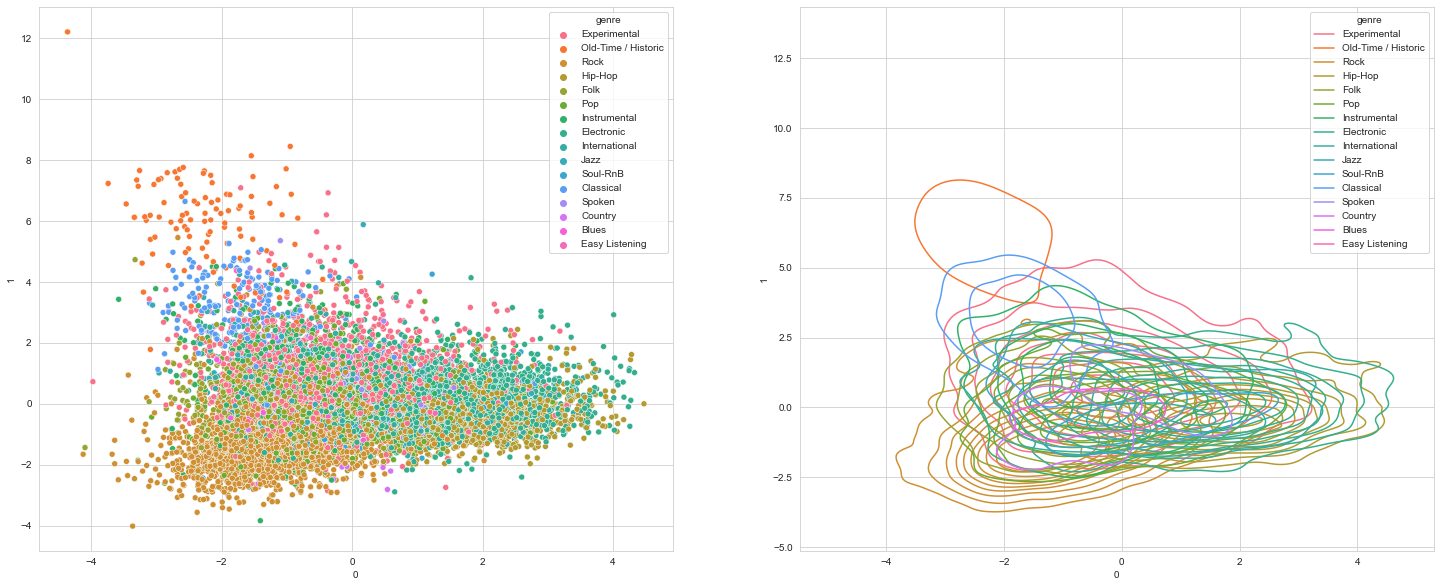

In [198]:
_, axs = plt.subplots(1, 2, figsize=(25, 10))
sns.scatterplot(data=train_set_2d, x=0, y=1, hue='genre', ax=axs[0])
sns.kdeplot(data=train_set_2d, x=0, y=1, hue='genre', ax=axs[1])
plt.show()

Preprocessing the features for training the models

In [199]:
# by default n_components = C - 1 = 16 - 1 = 15 in our case
LDA_15d = LinearDiscriminantAnalysis()

LDA_15d.fit(train_X, train_y)
train_X_15d = pd.DataFrame(LDA_15d.transform(train_X), index=train_X.index)
test_X_15d = pd.DataFrame(LDA_15d.transform(test_X), index=test_X.index)

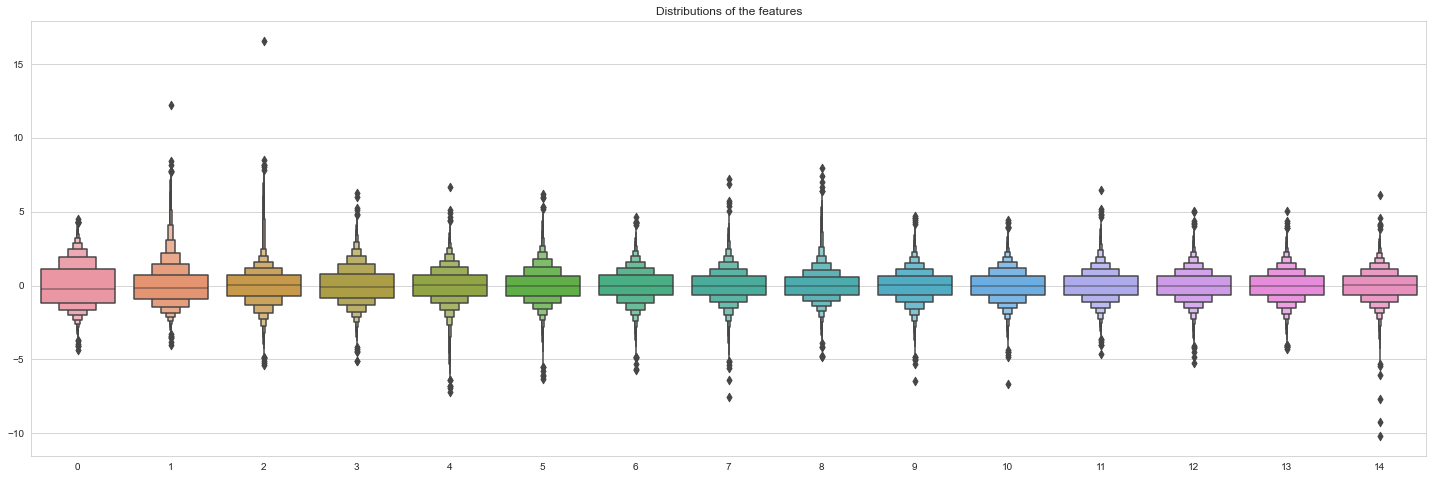

In [200]:
plt.figure(figsize=(25, 8))
sns.boxenplot(data=train_X_15d)
plt.title('Distributions of the features')
plt.show()

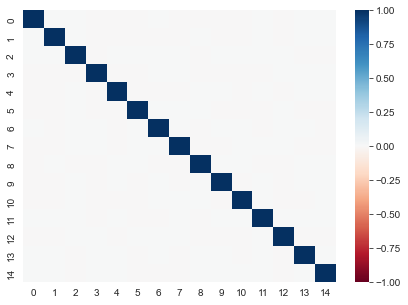

In [201]:
plt.figure(figsize=(7, 5))
sns.heatmap(train_X_15d.corr(), vmin=-1, vmax=1, cmap='RdBu')
plt.show()

# 3. Training the models

## 3.1 Logistic Regression

In [202]:
logistic_regression = LogisticRegression(multi_class='multinomial', solver='sag', random_state=123, max_iter=500)

logistic_regression.fit(train_X_15d, train_y)

LogisticRegression(max_iter=500, multi_class='multinomial', random_state=123,
                   solver='sag')

In [203]:
y_pred_logistic = pd.Series(logistic_regression.predict(test_X_15d), index=test_X_15d.index)

In [204]:
me_logistic = ClassificationEvaluation(
    model_name=f'Logistic Regression',
    model=logistic_regression,
    train_X=train_X_15d,
    train_y=train_y,
    val_X=test_X_15d,
    val_y=test_y
)

In [205]:
me_logistic.get_scores(on_sets=['train', 'validation'], average_type='weighted')

,train,validation
accuracy,0.650000,0.595000
precision (weighted),0.638839,0.577454
recall (weighted),0.650000,0.595000
f1 (weighted),0.639421,0.582240


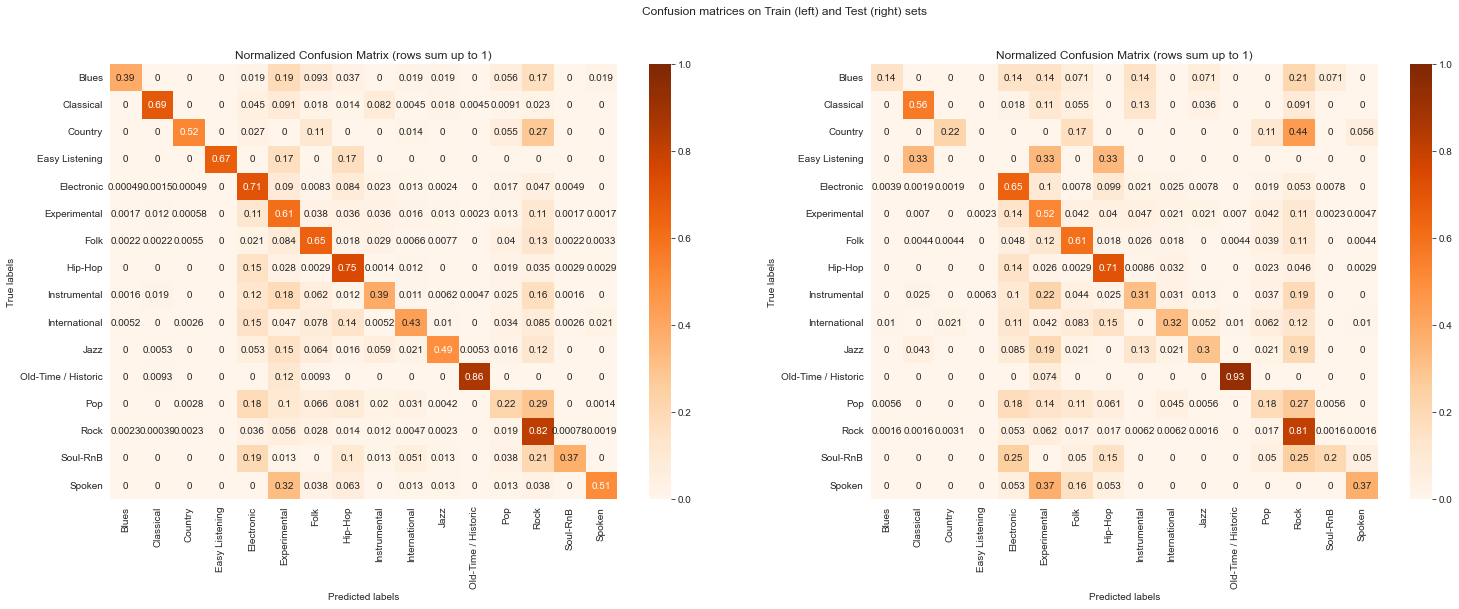

In [206]:
fig, axis = plt.subplots(1, 2, figsize=(25, 8))
fig.suptitle('Confusion matrices on Train (left) and Test (right) sets')
me_logistic.plot_confusion_matrix(ax=axis[0], on_set='train')
me_logistic.plot_confusion_matrix(ax=axis[1], on_set='validation')

From the confusion matrices, we can observe the following:
- The model misclassifies a lot of the tracks as Electronic, Experimental and Rock
- The model confuses Easy Listening with Classical, Experimental and Hip-Hop
- The model confuses Rock with Country

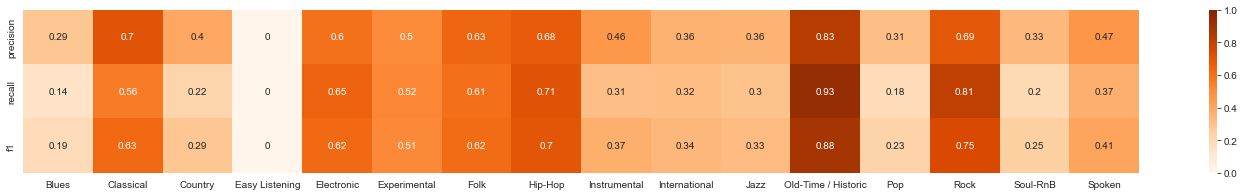

In [207]:
fig, axis = plt.subplots(1, 1, figsize=(25, 3))
me_logistic.plot_metrics_per_class(ax=axis, on_set='validation')

In [208]:
predicted_proba = pd.DataFrame(logistic_regression.predict_proba(test_X_15d), columns=logistic_regression.classes_, index=test_X_15d.index)

# For each row, assign the column whose value for the predicted probability is the highest
predicted_proba['genre'] = predicted_proba.idxmax(axis=1)

We can observe that the model is not very confident in the predictions, judging by the predicted probabilities for the genres.
Note that the figures below do not indicate that the model has classified the tracks correctly. Rather, they show the level of confidence the model has in its classification of the samples.

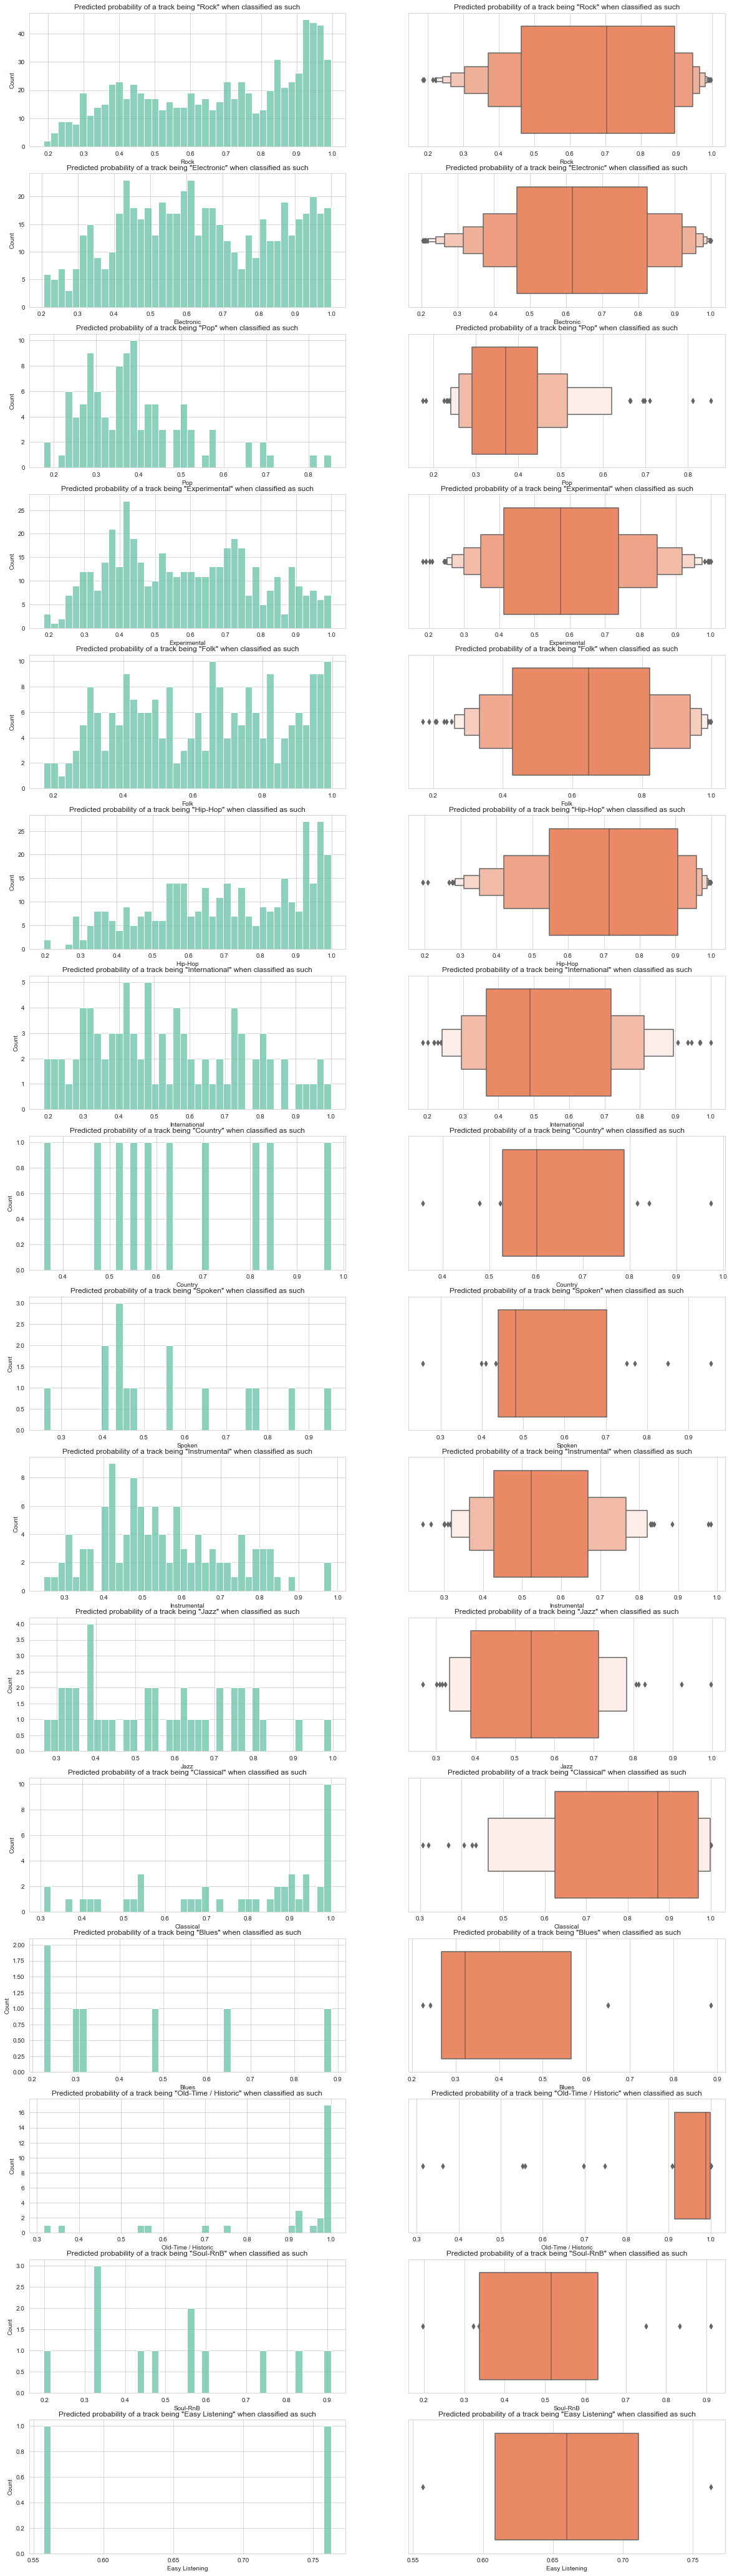

In [209]:
num_genres = predicted_proba['genre'].nunique()
ax_idxs = [(i, j) for i in range(num_genres) for j in range(2)]

fig, axs = plt.subplots(num_genres, 2, figsize=(20, 75))

k = 0
for genre in predicted_proba['genre'].unique():
    ax1_idx, ax2_idx = ax_idxs[k], ax_idxs[k + 1]
    ax1, ax2 = axs[ax1_idx[0]][ax1_idx[1]], axs[ax2_idx[0]][ax2_idx[1]]

    ax1.set_title(f'Predicted probability of a track being "{genre}" when classified as such')
    ax2.set_title(f'Predicted probability of a track being "{genre}" when classified as such')

    sns.histplot(x=predicted_proba[predicted_proba['genre'] == genre][genre], bins=40, ax=ax1)
    sns.boxenplot(x=predicted_proba[predicted_proba['genre'] == genre][genre], color='coral', ax=ax2)
    k += 2

## 3.2 Ensamble method
For this lab we will use the XGB classifier, since we already used a Random Forest in the decision_trees notebook.

In [210]:
train_X_15d, val_X_15d, train_y, val_y = train_test_split(train_X_15d, train_y, train_size=0.9, stratify=train_y, random_state=123)

In [211]:
label_encoder = LabelEncoder()
train_y = pd.Series(label_encoder.fit_transform(train_y), index=train_y.index)
val_y = pd.Series(label_encoder.transform(val_y), index=val_y.index)
test_y = pd.Series(label_encoder.transform(test_y), index=test_y.index)

In [212]:
xgb_classifier = XGBClassifier(
    max_depth=4,
    learning_rate=0.05,
    n_estimators=500,
    n_jobs=-1,
    verbosity=0,
    random_state=23,
    early_stopping_rounds=5
)

xgb_classifier.fit(
    train_X_15d,
    train_y,
    eval_set=[(val_X_15d, val_y)],
    verbose=False
)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=5, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=4, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=-1,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto', ...)

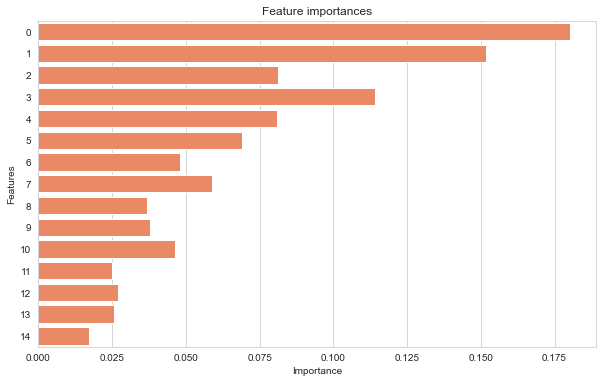

In [213]:
plt.figure(figsize=(10, 6))
importances = xgb_classifier.feature_importances_
indices = np.argsort(importances)[::-1]
names = [train_X_15d.columns[i] for i in indices]
sns.barplot(x=importances[indices], y=names, color='coral', orient='h')
plt.title('Feature importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [214]:
y_pred_xgb = pd.Series(xgb_classifier.predict(test_X_15d), index=test_X_15d.index)
y_pred_xgb = pd.Series(label_encoder.inverse_transform(y_pred_xgb), index=y_pred_xgb.index)
train_y = pd.Series(label_encoder.inverse_transform(train_y), index=train_y.index)
test_y = pd.Series(label_encoder.inverse_transform(test_y), index=test_y.index)

In [231]:
# to be able to use it in the ClassificationEvaluation class
class xbg_classifier_wrapper:
    def __init__(self, model, label_encoder) -> None:
        self.model = model
        self.label_encoder = label_encoder
        self.classes_ = model.classes_

    def predict(self, X):
        y_pred = pd.Series(self.model.predict(X), index=X.index)
        y_pred = pd.Series(self.label_encoder.inverse_transform(y_pred), index=y_pred.index)
        return y_pred

In [232]:
me_xgb = ClassificationEvaluation(
    model_name=f'XGB',
    model=xbg_classifier_wrapper(xgb_classifier, label_encoder),
    train_X=train_X_15d,
    train_y=train_y,
    val_X=test_X_15d,
    val_y=test_y
)

In [233]:
me_xgb.get_scores(on_sets=['train', 'validation'], average_type='weighted')

,train,validation
accuracy,0.734226,0.600000
precision (weighted),0.731573,0.580944
recall (weighted),0.734226,0.600000
f1 (weighted),0.728200,0.585286


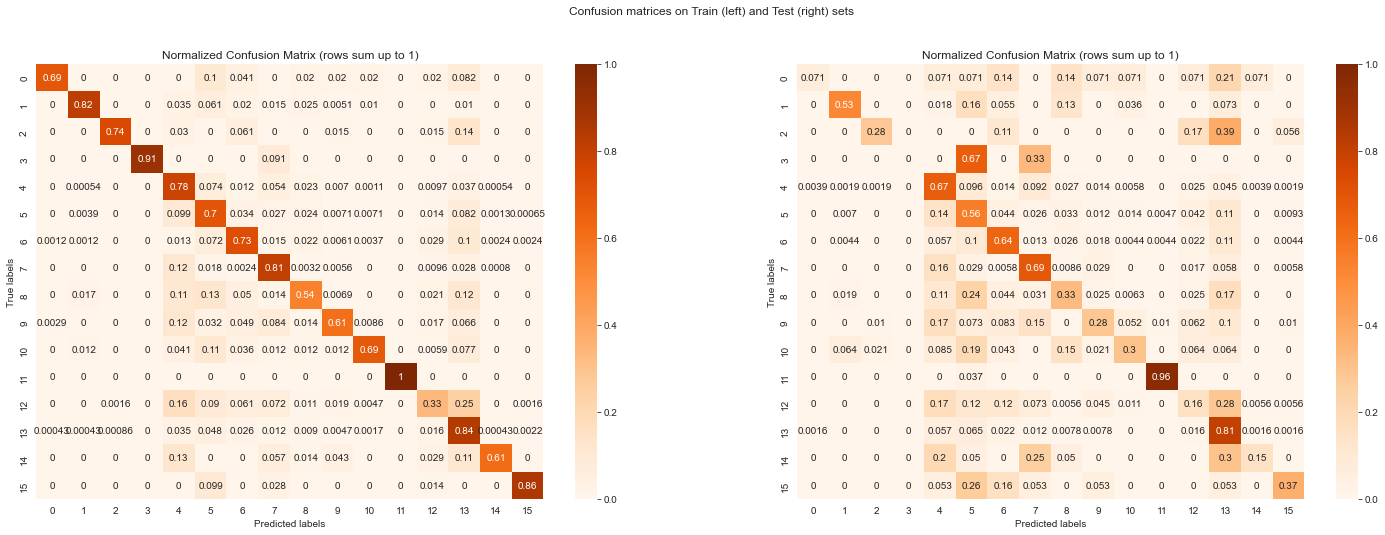

In [234]:
fig, axis = plt.subplots(1, 2, figsize=(25, 8))
fig.suptitle('Confusion matrices on Train (left) and Test (right) sets')
me_xgb.plot_confusion_matrix(ax=axis[0], on_set='train')
me_xgb.plot_confusion_matrix(ax=axis[1], on_set='validation')

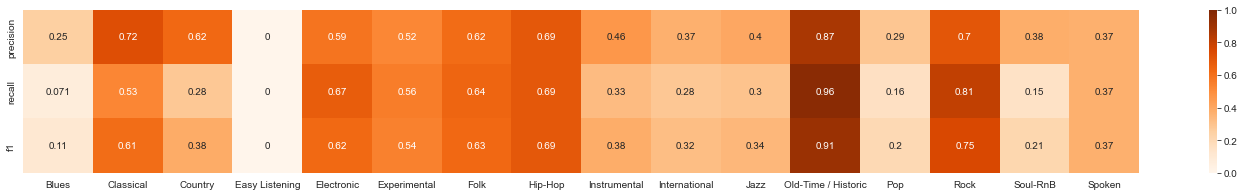

In [235]:
fig, axis = plt.subplots(1, 1, figsize=(25, 3))
me_xgb.plot_metrics_per_class(ax=axis, on_set='validation')